## **Image Classification with Tensorflow**

Nama : Yulia harni

Email: yuliaharni63@gmail.com

### Import TensorFlow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.14.0


### Import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extraction zip files

In [ ]:
import zipfile,os

zip_path = '/content/drive/MyDrive/rockpaperscissors.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Split Dataset

In [ ]:
import os
import shutil

# Ganti '/content/rockpaperscissors' dengan jalur dataset Anda
base_dir = '/content/rockpaperscissors'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Membuat direktori untuk set pelatihan dan validasi
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Daftar kategori (rock, paper, scissors)
categories = ['rock', 'paper', 'scissors']

# Pembagian proporsi untuk set validasi (contoh: 40% untuk validasi)
val_split_ratio = 0.4

# Memindahkan file ke direktori set pelatihan dan validasi
for category in categories:
    category_dir = os.path.join(base_dir, category)
    files = os.listdir(category_dir)

    # Jumlah file yang akan dipindahkan ke set validasi
    num_val_files = int(val_split_ratio * len(files))

    # File untuk set pelatihan
    train_files = files[num_val_files:]

    # File untuk set validasi
    val_files = files[:num_val_files]

    # Membuat direktori untuk setiap kategori di set pelatihan dan validasi
    train_category_dir = os.path.join(train_dir, category)
    val_category_dir = os.path.join(val_dir, category)

    os.makedirs(train_category_dir, exist_ok=True)
    os.makedirs(val_category_dir, exist_ok=True)

    # Memindahkan file ke direktori set pelatihan dan validasi
    for file in train_files:
        shutil.move(os.path.join(category_dir, file), os.path.join(train_category_dir, file))

    for file in val_files:
        shutil.move(os.path.join(category_dir, file), os.path.join(val_category_dir, file))


In [ ]:
os.listdir('/content/rockpaperscissors/train')

['paper', 'rock', 'scissors']

In [ ]:
os.listdir('/content/rockpaperscissors/val')

['paper', 'rock', 'scissors']

### ImageDataGenerator for training data and validation data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.4  # Specify the validation split here
)

In [ ]:
# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir, # direktori data latih
    target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=4,
    # karena ini merupakan masalah klasifikasi 3 kelas, gunakan class_mode = 'categorical'
    class_mode='categorical'
    # subset = 'training'
)


# Create the validation data generator
validation_generator = train_datagen.flow_from_directory(
    val_dir, # direktori data latih
    target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=4,
    # karena ini merupakan masalah klasifikasi 3 kelas, gunakan class_mode = 'categorical'
    class_mode='categorical'
    # subset = 'validation'

)


Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


### Create ModelCheckpoint callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Create ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Create EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

### Convolutional Neural Network (CNN) Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

# Assuming your images are resized to 150x150 pixels with 3 channels (RGB)
height = 150
width = 150
channels = 3

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

### Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

### Train model with model.fit

In [ ]:
model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=20, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/20
25/25 - 17s - loss: 0.1208 - accuracy: 0.9600 - val_loss: 0.1266 - val_accuracy: 0.9500 - 17s/epoch - 673ms/step
Epoch 2/20
25/25 - 17s - loss: 0.0494 - accuracy: 0.9600 - val_loss: 0.0016 - val_accuracy: 1.0000 - 17s/epoch - 697ms/step
Epoch 3/20
25/25 - 17s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 3.2704e-04 - val_accuracy: 1.0000 - 17s/epoch - 697ms/step
Epoch 4/20
25/25 - 17s - loss: 0.0553 - accuracy: 0.9800 - val_loss: 0.0070 - val_accuracy: 1.0000 - 17s/epoch - 692ms/step
Epoch 5/20
25/25 - 16s - loss: 0.0440 - accuracy: 0.9796 - val_loss: 0.0129 - val_accuracy: 1.0000 - 16s/epoch - 657ms/step
Epoch 6/20
25/25 - 16s - loss: 0.0304 - accuracy: 0.9900 - val_loss: 0.0191 - val_accuracy: 1.0000 - 16s/epoch - 648ms/step
Epoch 7/20
25/25 - 17s - loss: 0.0411 - accuracy: 0.9600 - val_loss: 0.0076 - val_accuracy: 1.0000 - 17s/epoch - 695ms/step
Epoch 8/20
25/25 - 17s - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.1576 - val_accuracy: 0.9000 - 17s/epoch - 673ms/step
Epoc

### Train model with Callback  Early Stoping

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/5
328/328 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9771
Epoch 1: val_accuracy improved from 0.98853 to 0.98968, saving model to best_model.h5
328/328 [==============================] - 266s 808ms/step - loss: 0.0453 - accuracy: 0.9771 - val_loss: 0.0336 - val_accuracy: 0.9897
Epoch 2/5
328/328 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9954
Epoch 2: val_accuracy did not improve from 0.98968
328/328 [==============================] - 260s 794ms/step - loss: 0.0217 - accuracy: 0.9954 - val_loss: 0.0877 - val_accuracy: 0.9839
Epoch 3/5
328/328 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9931
Epoch 3: val_accuracy did not improve from 0.98968
328/328 [==============================] - 263s 800ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.0703 - val_accuracy: 0.9817
Epoch 4/5
328/328 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9885
Epoch 4: val_accuracy did n

### Testing the model to predict new images

Saving photo_2023-11-20_11-14-50.jpg to photo_2023-11-20_11-14-50 (1).jpg
1/1 [==============================] - 0s 64ms/step
paper


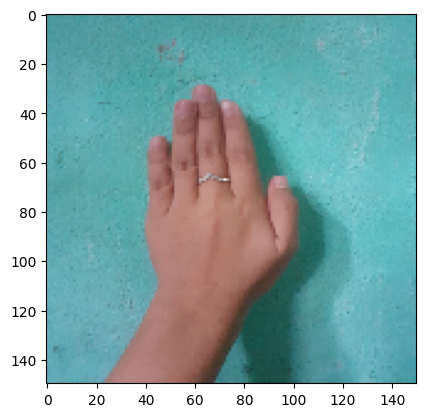

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

# Assuming classes is an array or list
  for class_probabilities in classes:
        # Assuming class_probabilities is an array of class probabilities
        predicted_class = class_probabilities.argmax()

        if predicted_class == 0:
            print('paper')
        elif predicted_class == 1:
            print('rock')
        else:
            print('scissors')